In [1]:
%matplotlib inline
import numpy as np
from pandas import DataFrame as df
import UserResults as ur
from Classifiers import TransparentRidge
from Classifiers import TransparentLasso
from scipy.sparse import diags
import matplotlib.pyplot as plt
import UserMatrix as um
import pickle
import PredictiveModels as pm
import pandas as pd

In [2]:
ratings = np.genfromtxt('postprocessed-data/user_ratings', delimiter=',', dtype=int)
movies = np.genfromtxt('postprocessed-data/movie_list', delimiter='|', dtype=str)

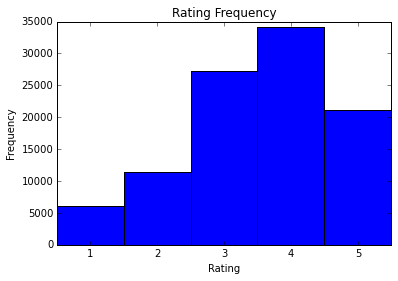

In [3]:
x = ratings.flat
his = np.histogram(x, bins = range(1,7))
fig, ax = plt.subplots()
offset = 0.5
plt.bar(his[1][1:],his[0],width=1)
ax.set_xticks(his[1][1:] + offset)
ax.set_xticklabels( ('1', '2', '3', '4', '5', '6') )
plt.title("Rating Frequency")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

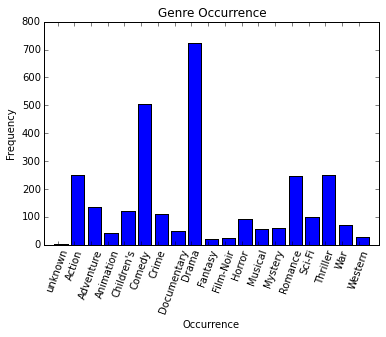

In [4]:
genres = np.genfromtxt('ml-100k/u.item', delimiter='|', usecols=range(5, 24))
genre_names = np.genfromtxt('ml-100k/u.genre', delimiter='|', dtype=str, usecols=0)
x = np.sum(genres, axis=0)
his = np.histogram(x, bins = range(0,20))
fig, ax = plt.subplots()
offset = -.2
plt.bar(his[1][1:],x,align='center')
ax.set_xticks(his[1][1:] + offset)
ax.set_xticklabels((list(genre_names)))
locs, labels = plt.xticks()
plt.setp(labels, rotation=70)
plt.title("Genre Occurrence")
plt.xlabel("Occurrence")
plt.ylabel("Frequency")
plt.show()

In [5]:
keyword_matrix = np.genfromtxt('postprocessed-data/keywords_matrix', delimiter=',', dtype=int)
keywords = np.genfromtxt('postprocessed-data/keyword_list', dtype=str)
frequency = np.sum(keyword_matrix, axis=0)
indices = np.argsort(frequency)[::-1]
keyword_df = df((np.column_stack((keywords[indices], frequency[indices]))), columns = ("Keyword", "Frequency"))
print keyword_df.head(20)

                         Keyword Frequency
0               independent-film       480
1                         murder       414
2                          death       320
3      husband-wife-relationship       300
4                 based-on-novel       296
5                           love       292
6                       violence       287
7                      cult-film       276
8      title-spoken-by-character       274
9                     friendship       270
10                         blood       268
11       father-son-relationship       261
12          family-relationships       256
13                 female-nudity       254
14       character-name-in-title       253
15                           sex       243
16                        police       236
17             cigarette-smoking       235
18       mother-son-relationship       223
19  father-daughter-relationship       220


In [6]:
actor_matrix = np.genfromtxt('postprocessed-data/actor_and_actress_matrix', delimiter=',')
actors_file = open("postprocessed-data/pop_actor_set")
actors = np.array(actors_file.read().splitlines())
actors_file.close()
frequency = np.sum(actor_matrix, axis=0)
indices = np.argsort(frequency)[::-1]
keyword_df = df((np.column_stack((actors[indices], frequency[indices]))), columns = ("Actor", "Frequency"))
keyword_df = keyword_df.convert_objects(convert_numeric=True)
print keyword_df.head(20)

                          Actor  Frequency
0                 Welker, Frank         33
1                   Banks, Lena         22
2                 Flowers, Bess         20
3              Harris, Sam (II)         19
4                Buscemi, Steve         19
5                   Hedaya, Dan         18
6            Jackson, Samuel L.         18
7           Rosales Jr., Thomas         18
8               De Niro, Robert         17
9                 Moratz, Ralph         16
10             Goldberg, Whoopi         16
11           von Bargen, Daniel         16
12  Lucas, Marshall Dancing Elk         16
13             Berkeley, Xander         15
14                DeVito, Danny         15
15            Howard, Rance (I)         15
16                Tovey, Arthur         15
17               Keitel, Harvey         15
18            Jones, James Earl         15
19               Walter, Tracey         15


In [7]:
import random
sample = random.sample(range(1, 946), 100)
sample_matrices = list()
for user_id in sample:
        sample_matrices.append(um.get_user_matrix(user_id, ratings))

In [8]:
alphas = np.arange(.05,.8,.05)
min_lasso_mae = 1
avg_mae_list =list()
for alpha in alphas:
    mae_list = list()
    for user_matrix in sample_matrices:
        results = pm.get_lasso_cv_results(user_matrix, alpha)
        mae_list.append(results[0])
    avg_mae = sum(mae_list) / float(len(mae_list))
    if avg_mae < min_lasso_mae:
        min_lasso_mae = avg_mae
        min_lasso_alpha = alpha
        min_lasso_maes = mae_list
    avg_mae_list.append(avg_mae)
print pd.DataFrame(np.column_stack((alphas,avg_mae_list)), columns = ['Alpha', 'MAE'])

    Alpha       MAE
0    0.05  0.811623
1    0.10  0.797854
2    0.15  0.800088
3    0.20  0.806516
4    0.25  0.816042
5    0.30  0.825968
6    0.35  0.835655
7    0.40  0.844939
8    0.45  0.853453
9    0.50  0.860255
10   0.55  0.865578
11   0.60  0.869393
12   0.65  0.871646
13   0.70  0.873162
14   0.75  0.874235


In [16]:
alphas = np.arange(11,40,2)
min_ridge_mae = 1
avg_mae_list =list()
for alpha in alphas:
    mae_list = list()
    for user_matrix in sample_matrices:
        results = pm.get_ridge_cv_results(user_matrix, alpha)
        mae_list.append(results[0])
    avg_mae = sum(mae_list) / float(len(mae_list))
    if avg_mae < min_ridge_mae:
        min_ridge_mae = avg_mae
        min_ridge_alpha = alpha
        min_ridge_maes = mae_list
    avg_mae_list.append(avg_mae)
print pd.DataFrame(np.column_stack((alphas,avg_mae_list)), columns = ['Alpha', 'MAE'])

    Alpha       MAE
0      11  0.813211
1      13  0.810685
2      15  0.808871
3      17  0.807600
4      19  0.806711
5      21  0.806086
6      23  0.805694
7      25  0.805507
8      27  0.805433
9      29  0.805454
10     31  0.805549
11     33  0.805699
12     35  0.805890
13     37  0.806124
14     39  0.806380


In [17]:
print "Optimal alpha is: ", min_lasso_alpha
lasso_df = pd.DataFrame(np.column_stack((sample,min_lasso_maes)), columns = ['User ID', 'MAE'])
print "Minimum MAEs"
print lasso_df.sort('MAE', ascending = True).head(10)
print "Maximum MAEs"
print lasso_df.sort('MAE', ascending = True).tail(10)

Optimal alpha is:  0.1
Minimum MAEs
    User ID       MAE
82      552  0.360561
87      573  0.458003
90      624  0.473172
92      640  0.523199
83      893  0.524229
64      686  0.525949
61      171  0.526781
35      191  0.543913
41       84  0.550122
45      844  0.555185
Maximum MAEs
    User ID       MAE
26      914  1.132713
60      127  1.162163
46      475  1.190385
16      434  1.277145
55      228  1.337941
88      562  1.359236
49      448  1.385060
9       589  1.418727
1       732  1.427404
69      575  1.458164


In [18]:
print "Optimal alpha is: ", min_ridge_alpha
ridge_df = pd.DataFrame(np.column_stack((sample,min_ridge_maes)), columns = ['User ID', 'MAE'])
print "Minimum MAEs"
print ridge_df.sort('MAE', ascending = True).head(10)
print "Maximum MAEs"
print ridge_df.sort('MAE', ascending = True).tail(10)

Optimal alpha is:  27
Minimum MAEs
    User ID       MAE
82      552  0.349214
87      573  0.464836
90      624  0.469398
92      640  0.526957
64      686  0.541257
83      893  0.542556
18      523  0.548028
41       84  0.550496
5       864  0.553630
66      645  0.562424
Maximum MAEs
    User ID       MAE
26      914  1.109420
1       732  1.196696
46      475  1.206124
60      127  1.210761
55      228  1.231862
16      434  1.285933
69      575  1.293141
49      448  1.306868
88      562  1.307078
9       589  1.341156


In [19]:
user_id = 945
user_matrix = um.get_user_matrix(user_id, ratings)
user_ratings = ratings[user_id-1]
nonzero_ratings = user_ratings[np.nonzero(user_ratings)]
print "User average rating: ", np.average(nonzero_ratings)
print "Number of movies rated by this user: ", len(nonzero_ratings)

User average rating:  2.93939393939
Number of movies rated by this user:  66


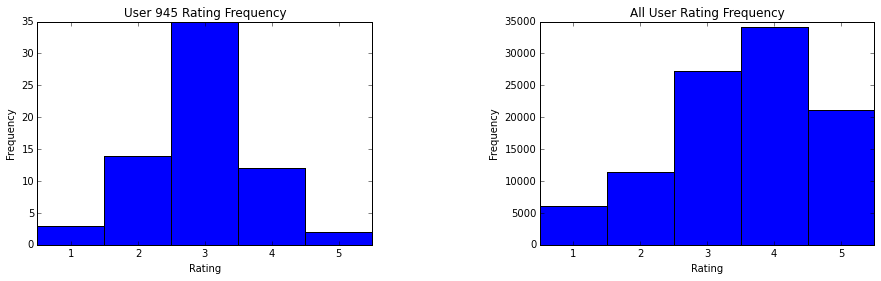

In [20]:
x = user_ratings
his = np.histogram(x, bins = range(1,7))
fig, axs = plt.subplots(ncols=2, figsize=(15, 4))
offset = 0.5
axs[0].bar(his[1][1:], his[0], width=1);
axs[0].set_xticks(his[1][1:] + offset);
axs[0].set_xticklabels(('1', '2', '3', '4', '5', '6'));
axs[0].set_title("User " + str(user_id) + " Rating Frequency");
axs[0].set_xlabel("Rating");
axs[0].set_ylabel("Frequency");

x = ratings.flat
his = np.histogram(x, bins = range(1,7));
offset = 0.5
axs[1].bar(his[1][1:], his[0], width=1);
axs[1].set_xticks(his[1][1:] + offset);
axs[1].set_xticklabels(('1', '2', '3', '4', '5', '6'));
axs[1].set_title("All User Rating Frequency");
axs[1].set_xlabel("Rating");
axs[1].set_ylabel("Frequency");
fig.subplots_adjust(wspace=.5)

In [22]:
indices = (user_matrix[:,0]-1).astype(int)
user_keyword_matrix = keyword_matrix[indices]
frequency = np.sum(user_keyword_matrix, axis=0)
indices = np.argsort(frequency)[::-1]
keyword_df = df((np.column_stack((keywords[indices], frequency[indices]))), columns = ("Keyword", "Frequency"))
print keyword_df.head(20)

                         Keyword Frequency
0                      cult-film        41
1                    blockbuster        31
2        character-name-in-title        29
3                          1990s        28
4      title-spoken-by-character        26
5   lifting-someone-into-the-air        25
6                         rescue        22
7                surprise-ending        22
8                            dog        21
9            falling-from-height        19
10                      violence        19
11                     flashback        17
12                       revenge        16
13              good-versus-evil        16
14             slow-motion-scene        15
15                        police        15
16                     explosion        15
17                    friendship        15
18                        escape        15
19                        murder        15


In [23]:
pd.set_option('display.width', 100)
results = pm.get_lasso_cv_results(user_matrix, [15])
results_df = ur.gen_user_results_old(user_id, results)
print "Top ten predictions"
print results_df.head(10)
print "\nBottom ten predictions"
print results_df.tail(10)

Top ten predictions
  Movie ID Average Rating   Error from Avg User Rating Model Prediction      Model Error
0    224.0  2.90909090909  0.0909090909091         3.0    2.96226415094  0.0377358490566
1    203.0  3.83238636364   0.832386363636         3.0    2.96226415094  0.0377358490566
2    221.0  3.65940054496   0.659400544959         3.0    2.96226415094  0.0377358490566
3    249.0  3.47738693467   0.477386934673         3.0    2.96226415094  0.0377358490566
4     81.0  3.71102661597    0.71102661597         3.0    2.96226415094  0.0377358490566
5    311.0  3.16049382716    0.16049382716         3.0    2.96226415094  0.0377358490566
6    362.0  2.72916666667   0.270833333333         3.0    2.96226415094  0.0377358490566
7    378.0  2.97727272727  0.0227272727273         3.0    2.96226415094  0.0377358490566
8    391.0  3.53623188406   0.536231884058         3.0    2.96226415094  0.0377358490566
9     66.0  3.02857142857  0.0285714285714         3.0    2.96226415094  0.0377358490566



In [24]:
clf =TransparentLasso(alpha=0.1)
user_cols = user_matrix.shape[1]
data = user_matrix[:, 1:(user_cols-1)]
target = user_matrix[:, (user_cols-1)]
clf.fit(data,target)
weights = clf.coef_
neg_evi, pos_evi = clf.predict_evidences(data)
bias = clf.get_bias()
y_pred = clf.predict(data)
indices = np.argsort(y_pred)
coef_diags = diags(clf.coef_, 0)
dm = data * coef_diags

In [25]:
pos_df, neg_df = ur.get_weights_and_features(weights)
print pos_df
print neg_df

         Features   Weights
0  Average Rating  0.309845
           Features   Weights
0         explosion -0.166968
1  good-versus-evil -0.029536


In [27]:
j = indices[-1]
movie_id = user_matrix[j][0]
res = um.get_avg_rating_for_movie(ratings, movie_id-1)
avg_rating = res[0]
num_rating = res[1]
movie_features = ur.gen_movie_weights(movie_id,dm,user_matrix)

print "Movie Title: ", movies[movie_id-1]
print "User Rating: ", user_ratings[movie_id-1]
print "Average Rating: ", avg_rating
print "Number of Ratings: ", num_rating

Movie Title:  Shawshank Redemption, The (1994)
User Rating:  5
Average Rating:  4.44210526316
Number of Ratings:  285


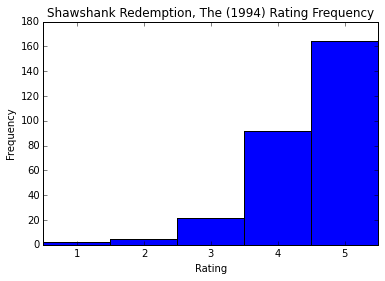

In [28]:
x = ratings[:,(movie_id-1)]
his = np.histogram(x, bins = range(1,7))
fig, ax = plt.subplots()
offset = 0.5
plt.bar(his[1][1:],his[0],width=1)
ax.set_xticks(his[1][1:] + offset)
ax.set_xticklabels( ('1', '2', '3', '4', '5', '6') )
plt.title(str(movies[movie_id-1]) + " Rating Frequency")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

In [29]:
print "Prediction: ",  clf.predict(data[j])[0]
print "Bias and evidences:", bias, neg_evi[j], pos_evi[j]
print "Positive Features"
print movie_features[0].head(10)
print "Negative Features"
print movie_features[1].head(10)

Prediction:  3.54895598899
Bias and evidences: 2.9845013378 0.0 0.56445465119
Positive Features
          Feature  Weights
0  Average Rating   0.5645
Negative Features
Empty DataFrame
Columns: [Feature, Weights]
Index: []


In [30]:
j = indices[0]
movie_id = user_matrix[j][0]
res = um.get_avg_rating_for_movie(ratings, movie_id-1)
avg_rating = res[0]
num_rating = res[1]
movie_features = ur.gen_movie_weights(movie_id,dm,user_matrix)
print "Movie Title: ", movies[movie_id-1]
print "User Rating: ", user_ratings[movie_id-1]
print "Average Rating: ", avg_rating
print "Number of Ratings: ", num_rating

Movie Title:  Naked Gun 33 1/3: The Final Insult (1994)
User Rating:  2
Average Rating:  2.0625
Number of Ratings:  32


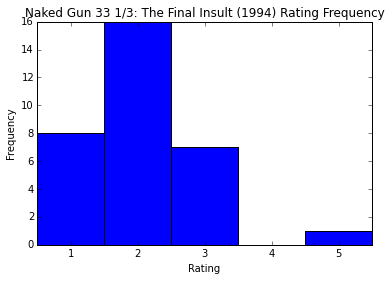

In [32]:
x = ratings[:,(movie_id-1)]
his = np.histogram(x, bins = range(1,7))
fig, ax = plt.subplots()
offset = 0.5
plt.bar(his[1][1:],his[0],width=1)
ax.set_xticks(his[1][1:] + offset)
ax.set_xticklabels( ('1', '2', '3', '4', '5', '6') )
plt.title(str(movies[movie_id-1]) + " Rating Frequency")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

In [33]:
print "Prediction: ",  clf.predict(data[j])[0]
print "Bias and evidences:", bias, neg_evi[j], pos_evi[j]
print "Positive Features"
print movie_features[0].head(10)
print "Negative Features"
print movie_features[1].head(10)

Prediction:  2.16744545752
Bias and evidences: 2.9845013378 -0.817055880275 0.0
Positive Features
Empty DataFrame
Columns: [Feature, Weights]
Index: []
Negative Features
          Feature  Weights
0  Average Rating  -0.6501
1       explosion  -0.1670


In [34]:
j = np.argsort(neg_evi)[0]
movie_id = user_matrix[j][0]
res = um.get_avg_rating_for_movie(ratings, movie_id-1)
avg_rating = res[0]
num_rating = res[1]
movie_features = ur.gen_movie_weights(movie_id,dm,user_matrix)
print "Movie Title: ", movies[movie_id-1]
print "User Rating: ", user_ratings[movie_id-1]
print "Average Rating: ", avg_rating
print "Number of Ratings: ", num_rating

Movie Title:  Naked Gun 33 1/3: The Final Insult (1994)
User Rating:  2
Average Rating:  2.0625
Number of Ratings:  32


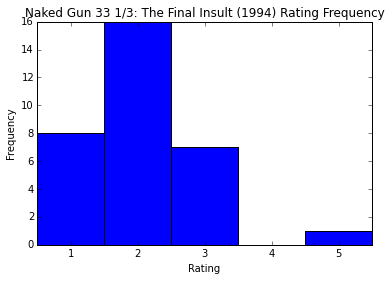

In [35]:
x = ratings[:,(movie_id-1)]
his = np.histogram(x, bins = range(1,7))
fig, ax = plt.subplots()
offset = 0.5
plt.bar(his[1][1:],his[0],width=1)
ax.set_xticks(his[1][1:] + offset)
ax.set_xticklabels( ('1', '2', '3', '4', '5', '6') )
plt.title(str(movies[movie_id-1]) + " Rating Frequency")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

In [36]:
print "Prediction: ",  clf.predict(data[j])[0]
print "Bias and evidences:", bias, neg_evi[j], pos_evi[j]
print "Positive Features"
print movie_features[0].head(10)
print "Negative Features"
print movie_features[1].head(10)

Prediction:  2.16744545752
Bias and evidences: 2.9845013378 -0.817055880275 0.0
Positive Features
Empty DataFrame
Columns: [Feature, Weights]
Index: []
Negative Features
          Feature  Weights
0  Average Rating  -0.6501
1       explosion  -0.1670


In [37]:
j = np.argsort(pos_evi)[-1]
movie_id = user_matrix[j][0]
res = um.get_avg_rating_for_movie(ratings, movie_id-1)
avg_rating = res[0]
num_rating = res[1]
movie_features = ur.gen_movie_weights(movie_id,dm,user_matrix)
print "Movie Title: ", movies[movie_id-1]
print "User Rating: ", user_ratings[movie_id-1]
print "Average Rating: ", avg_rating
print "Number of Ratings: ", num_rating

Movie Title:  Shawshank Redemption, The (1994)
User Rating:  5
Average Rating:  4.44210526316
Number of Ratings:  285


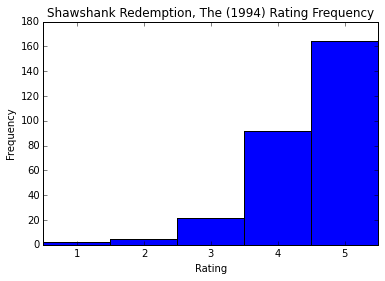

In [38]:
x = ratings[:,(movie_id-1)]
his = np.histogram(x, bins = range(1,7))
fig, ax = plt.subplots()
offset = 0.5
plt.bar(his[1][1:],his[0],width=1)
ax.set_xticks(his[1][1:] + offset)
ax.set_xticklabels( ('1', '2', '3', '4', '5', '6') )
plt.title(str(movies[movie_id-1]) + " Rating Frequency")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

In [39]:
print "Prediction: ",  clf.predict(data[j])[0]
print "Bias and evidences:", bias, neg_evi[j], pos_evi[j]
print "Positive Features"
print movie_features[0].head(10)
print "Negative Features"
print movie_features[1].head(10)

Prediction:  3.54895598899
Bias and evidences: 2.9845013378 0.0 0.56445465119
Positive Features
          Feature  Weights
0  Average Rating   0.5645
Negative Features
Empty DataFrame
Columns: [Feature, Weights]
Index: []


In [41]:
conflict = np.min([abs(neg_evi), pos_evi], axis=0)
indices = np.argsort(conflict)
j=indices[-1]
movie_id = user_matrix[j][0]
res = um.get_avg_rating_for_movie(ratings, movie_id-1)
avg_rating = res[0]
num_rating = res[1]
movie_features = ur.gen_movie_weights(movie_id,dm,user_matrix)
print "Movie Title: ", movies[movie_id-1]
print "User Rating: ", user_ratings[movie_id-1]
print "Average Rating: ", avg_rating
print "Number of Ratings: ", num_rating

Movie Title:  Men in Black (1997)
User Rating:  3
Average Rating:  3.74426229508
Number of Ratings:  305


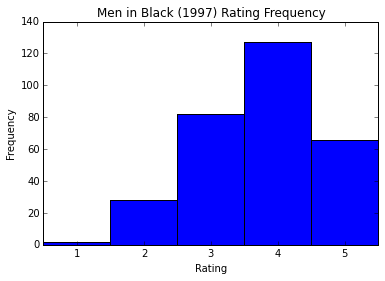

In [42]:
x = ratings[:,(movie_id-1)]
his = np.histogram(x, bins = range(1,7))
fig, ax = plt.subplots()
offset = 0.5
plt.bar(his[1][1:],his[0],width=1)
ax.set_xticks(his[1][1:] + offset)
ax.set_xticklabels( ('1', '2', '3', '4', '5', '6') )
plt.title(str(movies[movie_id-1]) + " Rating Frequency")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

In [43]:
print "Prediction: ",  clf.predict(data[j])[0]
print "Bias and evidences:", bias, neg_evi[j], pos_evi[j]
print "Positive Features"
print movie_features[0].head(10)
print "Negative Features"
print movie_features[1].head(10)

Prediction:  2.99793488294
Bias and evidences: 2.9845013378 -0.196503503655 0.209937048797
Positive Features
          Feature  Weights
0  Average Rating   0.2099
Negative Features
            Feature  Weights
0         explosion  -0.1670
1  good-versus-evil  -0.0295


In [44]:
information = np.max([abs(neg_evi), pos_evi], axis=0)
indices = np.argsort(information)
j=indices[0]
movie_id = user_matrix[j][0]
res = um.get_avg_rating_for_movie(ratings, movie_id-1)
avg_rating = res[0]
num_rating = res[1]
movie_features = ur.gen_movie_weights(movie_id,dm,user_matrix)
print "Movie Title: ", movies[movie_id-1]
print "User Rating: ", user_ratings[movie_id-1]
print "Average Rating: ", avg_rating
print "Number of Ratings: ", num_rating

Movie Title:  Robin Hood: Men in Tights (1993)
User Rating:  3
Average Rating:  3.30769230769
Number of Ratings:  13


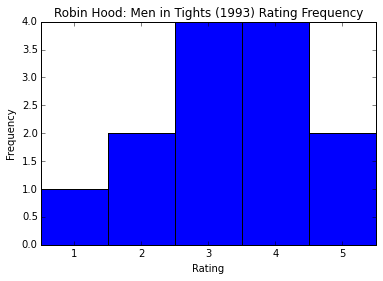

In [45]:
x = ratings[:,(movie_id-1)]
his = np.histogram(x, bins = range(1,7))
fig, ax = plt.subplots()
offset = 0.5
plt.bar(his[1][1:],his[0],width=1)
ax.set_xticks(his[1][1:] + offset)
ax.set_xticklabels( ('1', '2', '3', '4', '5', '6') )
plt.title(str(movies[movie_id-1]) + " Rating Frequency")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

In [46]:
print "Prediction: ",  clf.predict(data[j])[0]
print "Bias and evidences:", bias, neg_evi[j], pos_evi[j]
print "Positive Features"
print movie_features[0].head(10)
print "Negative Features"
print movie_features[1].head(10)

Prediction:  2.98309849075
Bias and evidences: 2.9845013378 -0.00140284704599 0.0
Positive Features
Empty DataFrame
Columns: [Feature, Weights]
Index: []
Negative Features
          Feature  Weights
0  Average Rating  -0.0014


In [47]:
user_cols = user_matrix.shape[1]
data = user_matrix[:, 1:(user_cols-1)]
target = user_matrix[:, (user_cols-1)]
user_rated = user_matrix[:, 0]-1
movie_file = open("postprocessed-data/movie_matrix", "r")
movie_matrix = pickle.load(movie_file)[:, 1:]
movie_file.close()

In [55]:
clf =TransparentRidge(min_ridge_alpha)
clf.fit(data,target)
all_pred = clf.predict(movie_matrix)
unrated_pred = np.delete(all_pred, user_rated, 0)
indices = np.argsort(unrated_pred)[::-1]
unrated_movies = np.delete(movies, user_rated, 0)
sorted_movies = unrated_movies[indices]
movie_df = pd.DataFrame(np.column_stack((sorted_movies,unrated_pred[indices])), columns = ['Movie', 'Prediction'])
print "Top predicted movies"
print movie_df.head(10)
print "Lowest predicted movies"
print movie_df.tail(10)

Top predicted movies
                            Movie     Prediction
0       Return of the Jedi (1983)   50.994018128
1                    Fargo (1996)  50.7376931836
2                Breakdown (1997)  48.6952075538
3            Marvin's Room (1996)  48.5748421162
4                    Evita (1996)  48.0531088791
5                 In & Out (1997)  43.8405757006
6  Raiders of the Lost Ark (1981)  42.5418085481
7           Godfather, The (1972)  42.1090390139
8            Jerry Maguire (1996)  39.3309101086
9                Rock, The (1996)  38.3047593976
Lowest predicted movies
                              Movie     Prediction
1605  Terror in a Texas Town (1958)  3.31584365583
1606   Falling in Love Again (1980)  3.27907326987
1607   Price Above Rubies, A (1998)  3.27455081717
1608        King of New York (1990)  3.26400945585
1609                Hedd Wyn (1992)   3.2629022606
1610            Shooter, The (1995)  3.19425281317
1611                   Flirt (1995)  3.16940161043
1612    

In [58]:
clf =TransparentRidge(alpha=0.1)
clf.fit(data,target)
all_pred = clf.predict(movie_matrix)
unrated_pred = np.delete(all_pred, user_rated, 0)
indices = np.argsort(unrated_pred)[::-1]
unrated_movies = np.delete(movies, user_rated, 0)
sorted_movies = unrated_movies[indices]
movie_df = pd.DataFrame(np.column_stack((sorted_movies,unrated_pred[indices])), columns = ['Movie', 'Prediction'])
print "Top predicted movies"
print movie_df.head(10)
print "Lowest predicted movies"
print movie_df.tail(10)

Top predicted movies
                            Movie     Prediction
0                    Fargo (1996)  15.6470440393
1       Return of the Jedi (1983)  15.6347128249
2            Marvin's Room (1996)  14.8304967366
3                    Evita (1996)  14.4549789963
4                Breakdown (1997)  14.2496464503
5                 In & Out (1997)  13.7008348248
6  Raiders of the Lost Ark (1981)  13.3447637926
7           Godfather, The (1972)   13.267243599
8                Rock, The (1996)  12.4698823397
9            Jerry Maguire (1996)  12.1078271422
Lowest predicted movies
                                   Movie     Prediction
1605             Leading Man, The (1996)  2.63766836283
1606  Journey of August King, The (1995)  2.54301809378
1607                   Body Parts (1991)  2.52744686007
1608                  Double Team (1997)  2.50438923604
1609            Some Mother's Son (1996)   2.4880380385
1610                        Flirt (1995)  2.47621372002
1611                Shoo